# Tutorial of  puzzle solver

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JulienNonin/jigsaw-puzzle-solver/blob/master/sandbox.ipynb)

### setup environment

- Execute if in Colab:

In [ ]:
! git clone https://github.com/JulienNonin/jigsaw-puzzle-solver.git

In [ ]:
cd jigsaw-puzzle-solver

- Execute if in jupyter notebook:

In [109]:
!pip install -r requirements.txt

README.md        img              local.py         sandbox.ipynb
docs             jigsolver        requirements.txt tests


## Introduction
The idea of our project is to implement a puzzle solver which can generate puzzles in a custom way (according to the number of pieces, size, etc) and solve puzzles in different ways (according to different color spaces, different compatibility calculation methods, etc). 
<br>
Our project is inspired by [Pomeranz, D., Shemesh, M., & Ben-Shahar, O. (2011, June). A fully automated greedy square jigsaw puzzle solver. In CVPR 2011 (pp. 9-16). IEEE](https://www.cs.bgu.ac.il/~ben-shahar/Publications/2011-Pomeranz_Shemesh_and_Ben_Shahar-A_Fully_Automated_Greedy_Square_Jigsaw_Puzzle_Solver.pdf)

## Demonstrate
The following will demonstrate the main function of puzzle solver:

At first, we import all packages we need.

In [189]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from jigsolver.puzzle import Slot,Piece,Puzzle,nb_pieces,nb_rows_and_columns,patch
from jigsolver.metrics import *
from jigsolver.pomeranz_solver.placer import *
from jigsolver.pomeranz_solver.shifter import *
from jigsolver.pomeranz_solver.segmenter import *
from jigsolver.pomeranz_solver.solver import *
from copy import copy, deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Modelisation of a Piece

Here we created a piece with 3x3 pixels, we can get Top border of the piece and Bottom border of the piece easily. The main idea of the puzzle solver is based on comparing the compatibility between pieces.

Text(0.5, 1.0, 'Bottom border of the piece')

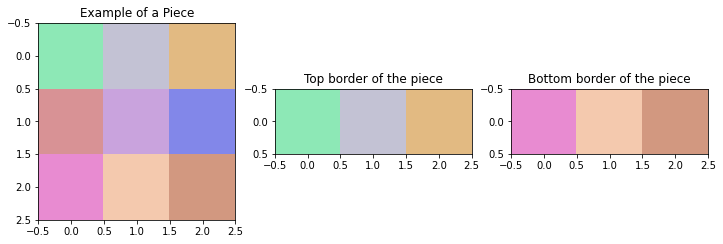

In [2]:
np.random.seed(1)
P=Piece(np.random.randint(255,size=(3,3,3)))
Q=Piece(np.random.randint(255,size=(3,3,3)))

plt.figure(figsize=(12,10))

plt.subplot(1,3,1)
plt.imshow(P.picture,alpha=0.5)
plt.title('Example of a Piece')

plt.subplot(1,3,2)
plt.imshow([P.get_border(Border.TOP)],alpha=0.5)
plt.title('Top border of the piece')

plt.subplot(1,3,3)
plt.imshow([P.get_border(Border.BOTTOM)],alpha=0.5)
plt.title('Bottom border of the piece')

### Modelisation of a puzzle

Here we show how to create a Puzzle. We can create it by three ways : 
- Giving a number of pieces specifying the initializer <code>nb_pieces</code>
- Giving a number of rows and number of columns specifying the initializer <code>nb_rows_and_columns</code>
- Giving a particular patch_size specifying the initializer <code>patch</code>

In [30]:
#import of the image
img_folder = 'img/'
img = plt.imread(img_folder + "eiffel.jpg")

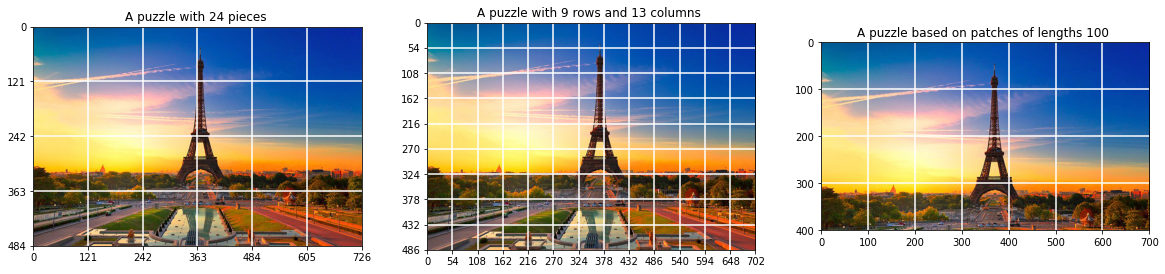

In [31]:
N=24
rows_and_columns=(9,13)
patch_size=100

plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
eiffel_puzzle = Puzzle(img,nb_pieces(N))
plt.title(f'A puzzle with {N} pieces ')
eiffel_puzzle.ground_truth.display()


plt.subplot(1,3,2)
eiffel_puzzle = Puzzle(img,nb_rows_and_columns(rows_and_columns))
plt.title(f'A puzzle with {rows_and_columns[0]} rows and {rows_and_columns[1]} columns ')
eiffel_puzzle.ground_truth.display()

plt.subplot(1,3,3)
eiffel_puzzle = Puzzle(img,patch(patch_size))
plt.title(f'A puzzle based on patches of lengths {100} ')
eiffel_puzzle.ground_truth.display()

You can easily change from one configuration to an other using the method <code> change_structure </code>

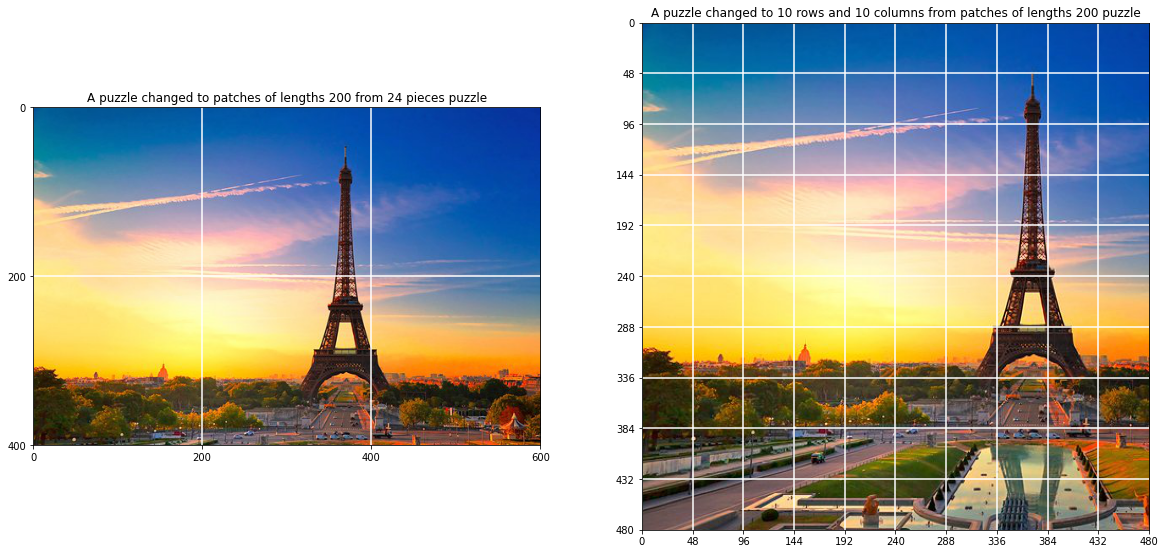

In [32]:
eiffel_puzzle = Puzzle(img,nb_pieces(N))

plt.figure(figsize=(20,20))

plt.subplot(1,2,1)

eiffel_puzzle.change_structure(patch(200,))
plt.title(f'A puzzle changed to patches of lengths 200 from {N} pieces puzzle')
eiffel_puzzle.ground_truth.display()


plt.subplot(1,2,2)
eiffel_puzzle.change_structure(nb_rows_and_columns((10,10)))
plt.title(f'A puzzle changed to 10 rows and 10 columns from patches of lengths 200 puzzle')
eiffel_puzzle.ground_truth.display()

### Prepare to play

When you create a puzzle, some pieces are created and gathered into a list called bag_of_pieces that you can obtain easily doing <code>MyPuzzle.bag_of_pieces</code>

Immediately after, these pieces are shuffled and the game can start.

When the game start, the player ground is empty. We will call this player ground a **Board**.

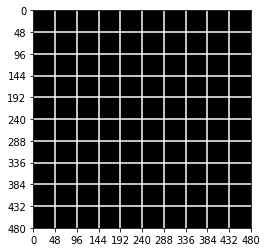

In [49]:
eiffel_puzzle.display()

Nevertheless, you can retrieve the original arrangement using <code>eiffel_puzzle.ground_truth</code>. 

This is done in order to be able to compute a performance metric which could enable us to compare many solvers based on their performances for some puzzles.

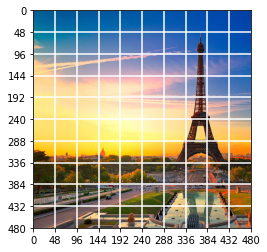

In [50]:
eiffel_puzzle.ground_truth.display()

When the game has started, the player has to place correctly the pieces from the bag of pieces into the Board.

Here we used the approach described by the paper  [Pomeranz, D., Shemesh, M., & Ben-Shahar, O. (2011, June). A fully automated greedy square jigsaw puzzle solver. In CVPR 2011 (pp. 9-16). IEEE](https://www.cs.bgu.ac.il/~ben-shahar/Publications/2011-Pomeranz_Shemesh_and_Ben_Shahar-A_Fully_Automated_Greedy_Square_Jigsaw_Puzzle_Solver.pdf) <br>

The approach consists in :
    - placing all the pieces on the board according to a certain compatibility metric. The first piece is placed randomly and then we place others place greedily based on this compatibility metric. This is done by an algorithm called 'The Placer'
    - keeping the part of the current solved puzzle which seems to be the highest well-arranged part. This is done by an algorithm called 'The segmenter'
    - Then, we should just alternate these two algorithms until we are satisfied. This operation is done by an algorithm called 'The shifter'

## Placer

Now, let's see how the puzzle solver place the pieces into board. We just create the puzzle and shuffle it as before.

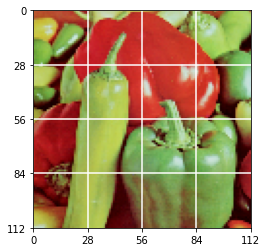

In [201]:
img = 255 * plt.imread("img/peppers.png")[:,:,:3]
#img = plt.imread("img/eiffel.jpg")
puzzle = Puzzle(img,patch(28))
puzzle.ground_truth.display()

We compute the compatibility matrix in the paper of [Pomeranz, D., Shemesh, M., & Ben-Shahar, O. (2011, June). A fully automated greedy square jigsaw puzzle solver. In CVPR 2011 (pp. 9-16). IEEE](https://www.cs.bgu.ac.il/~ben-shahar/Publications/2011-Pomeranz_Shemesh_and_Ben_Shahar-A_Fully_Automated_Greedy_Square_Jigsaw_Puzzle_Solver.pdf) <br><br>
The compatibility matrix contains the compatibilities values of each piece with each others. For example, if there are 100 pieces, the shape of the matrix should be 100x100.

**N.B. : The computation of the compatibility matrix will take some times if the puzzle is too big.**

In [202]:
CM = pomeranz_CM(puzzle)

To place the piece, the puzzle solver just choose the first piece and place it also randomly. 

Then, he checks which pieces seem to be the more adequates to be placed around it according to their compatibilities.

<br>At last, he do it again and again with the new pieces until the board is full. <br>

We call this method as greedy_placer.

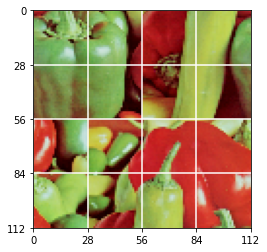

In [203]:
# The placer
puzzle.clean()
greedy_placer(puzzle, CM, rolling=False)
puzzle.display()

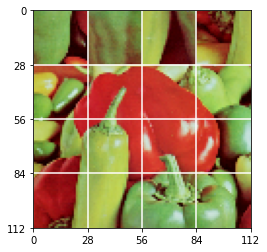

In [204]:
# New version of the placer with the rolling behaviour
puzzle.clean()
greedy_placer(puzzle, CM, rolling=True)
puzzle.display()

## Segmenter

After the board is full, the puzzle solver will reuse the compatibility matrix to find the best segment and keep it alone into the Board.

In [205]:
BB = BestBuddies_matrix(CM)

In [206]:
segment = segmenter(puzzle,BB)

In [207]:
remove_all_but_segment(puzzle,segment)

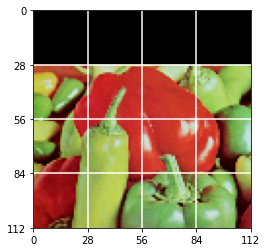

In [208]:
puzzle.display()

## Solver

Here, we show how to call the solver. It's in fact very simple, we just need a puzzle and a number of maximal iterations !

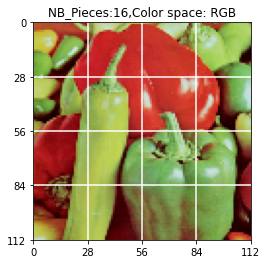

In [209]:
solve(puzzle,n_iter_max=3)

The puzzle has been correctly solved but maybe this is too easy, we can try we more pieces

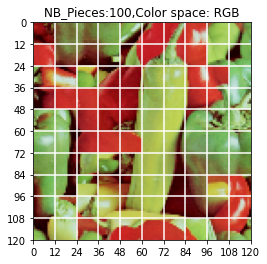

In [210]:
puzzle.change_structure(nb_pieces(100))
solve(puzzle,n_iter_max=3)

This time the result is not so good... Let's see if we use more iterations

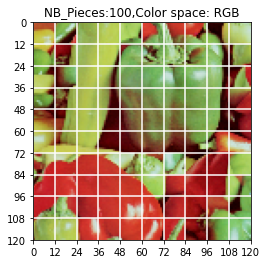

In [211]:
solve(puzzle,n_iter_max=10)

But we can also use another color space, by default the puzzle solver used RGB color space, but you can set it as Lab.<br> When we use Lab, there are just 3 iterations, but good enough than 10 iterations with RGB.

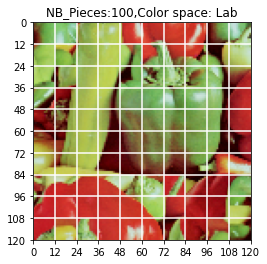

In [212]:
solve(puzzle,n_iter_max=3,lab_space_set=True)

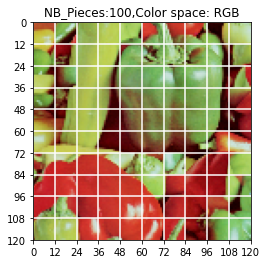

In [213]:
solve(puzzle,n_iter_max=10)

## Evaluation of our solver

We have challenged our solver with the same puzzle but cutted into different number of pieces in order to see if it has a significant impact on the solving. <br> In addition to selecting the color space, the puzzle solver can also automatically select the best result output. Just need to set auto_chose to True.

<Figure size 432x288 with 0 Axes>

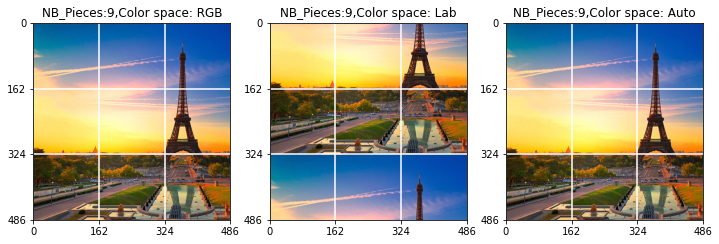

<Figure size 432x288 with 0 Axes>

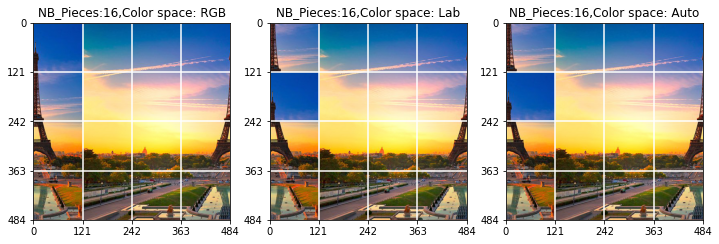

<Figure size 432x288 with 0 Axes>

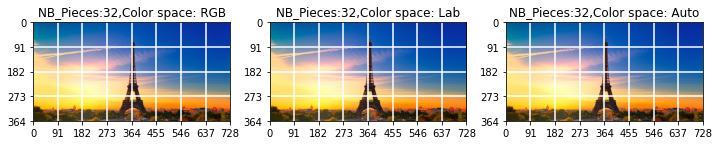

<Figure size 432x288 with 0 Axes>

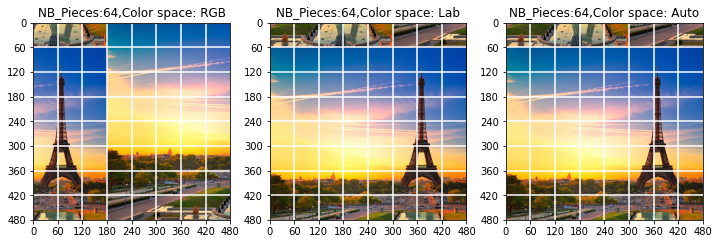

<Figure size 432x288 with 0 Axes>

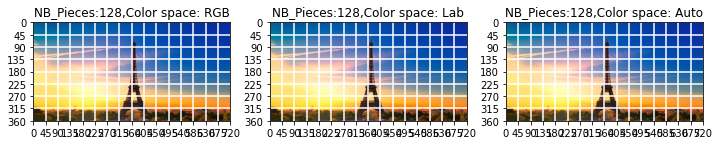

In [200]:
import pandas as pd
results=pd.DataFrame()
Simple_eval=[]
Neighbor_eval=[]
BB_eval=[]

Simple_eval_lab=[]
Neighbor_eval_lab=[]
BB_eval_lab=[]

NB_PIECES=[9,16,32,64,128]

for nb_piece in NB_PIECES:
    plt.figure()
    eiffel_puzzle.change_structure(nb_pieces(nb_piece))
    eiffel_puzzle.clean()
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.xlabel('')
    solve(eiffel_puzzle,n_iter_max=2)
    BB = BestBuddies_matrix(pomeranz_CM(eiffel_puzzle))
    Simple_eval.append(simple_evaluation(eiffel_puzzle.ground_truth,eiffel_puzzle))
    Neighbor_eval.append(neighbor_comparison(eiffel_puzzle.ground_truth,eiffel_puzzle))
    BB_eval.append(BestBuddies_metric(eiffel_puzzle,BB))
    
    plt.subplot(1,3,2) 
    eiffel_puzzle.clean()
    solve(eiffel_puzzle,n_iter_max=2,lab_space_set = True)
    BB_lab = BestBuddies_matrix(pomeranz_CM(eiffel_puzzle,lab_space=True))
    Simple_eval_lab.append(simple_evaluation(eiffel_puzzle.ground_truth,eiffel_puzzle))
    Neighbor_eval_lab.append(neighbor_comparison(eiffel_puzzle.ground_truth,eiffel_puzzle))
    BB_eval_lab.append(BestBuddies_metric(eiffel_puzzle,BB_lab))
    
    
    plt.subplot(1,3,3)
    eiffel_puzzle.clean()
    solve(eiffel_puzzle,n_iter_max=2, Auto_chose = True)

results['NB_PIECES']=NB_PIECES
results['Simple_eval_RGB']=Simple_eval
results['Simple_eval_lab']=Simple_eval_lab
results['Neighbor_eval_RGB']=Neighbor_eval
results['Neighbor_eval_lab']=Neighbor_eval_lab
results['BB_eval_RGB']=BB_eval
results['BB_eval_lab']=BB_eval_lab
results['eval_RGB']= [a+b+c for a,b,c in zip(BB_eval,Neighbor_eval,Simple_eval)]
results['eval_lab']= [a+b+c for a,b,c in zip(BB_eval_lab,Neighbor_eval_lab,Simple_eval_lab)]


In [214]:
results

,NB_PIECES,Simple_eval_RGB,Simple_eval_lab,Neighbor_eval_RGB,Neighbor_eval_lab,BB_eval_RGB,BB_eval_lab,eval_RGB,eval_lab
0,9,1.0,0.0,1.00,0.75,0.86,1.00,2.86,1.75
1,16,0.0,0.0,0.82,0.73,0.92,0.96,1.74,1.69
2,32,1.0,1.0,1.00,1.00,0.93,0.96,2.93,2.96
3,64,0.0,0.0,0.90,0.91,0.94,0.96,1.84,1.87
4,128,1.0,1.0,1.00,1.00,0.92,0.95,2.92,2.95


We can evaluate the puzzle solver based on the table and the photos.